In [29]:
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns  # Add this line
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Attention

In [7]:
data_dir = "archive"

In [8]:
# Get list of all audio files
file_paths = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".wav"):  # RAVDESS uses .wav files
            file_paths.append(os.path.join(root, file))


In [9]:
# Create DataFrame
df = pd.DataFrame(file_paths, columns=["file_path"])

In [10]:
# Extract emotion code from filename
df['emotion'] = df['file_path'].apply(lambda x: os.path.basename(x).split("-")[2])

In [11]:
# Class mapping (RAVDESS codes)
emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}
df['emotion'] = df['emotion'].map(emotion_map)

print(df.head())

                                   file_path  emotion
0  archive\Actor_01\03-01-01-01-01-01-01.wav  neutral
1  archive\Actor_01\03-01-01-01-01-02-01.wav  neutral
2  archive\Actor_01\03-01-01-01-02-01-01.wav  neutral
3  archive\Actor_01\03-01-01-01-02-02-01.wav  neutral
4  archive\Actor_01\03-01-02-01-01-01-01.wav     calm


In [13]:
def extract_mfcc(file_path, n_mfcc=40):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc = np.mean(mfcc.T, axis=0)  # Average over time
    return mfcc

In [14]:
# Extract features and labels
X = np.array([extract_mfcc(fp) for fp in df['file_path']])
y = df['emotion'].values

In [15]:
# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

In [16]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
from tensorflow.keras.models import Sequential

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(40, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(64),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 38, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,960 (148.28 KB)

 Trainable params: 37,960 (148.28 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Reshape data for CNN
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [25]:
# Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)]
)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.1559 - loss: 2.0753 - val_accuracy: 0.1735 - val_loss: 2.0263
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2226 - loss: 1.9850 - val_accuracy: 0.2213 - val_loss: 1.9300
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2478 - loss: 1.8828 - val_accuracy: 0.3124 - val_loss: 1.8139
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3019 - loss: 1.8228 - val_accuracy: 0.3037 - val_loss: 1.8096
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3351 - loss: 1.7764 - val_accuracy: 0.3341 - val_loss: 1.7367
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3355 - loss: 1.7458 - val_accuracy: 0.3167 - val_loss: 1.7833
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3555 - loss: 1.7403 - val_accuracy: 0.3514 - val_loss: 1.6714
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3704 - loss: 1.6881 - val_accuracy: 0.3796 - v

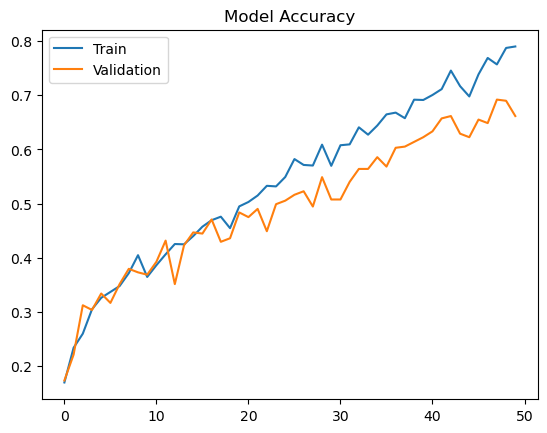

In [26]:
# Plot results
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.legend()
plt.show()

In [27]:
# Test accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6991 - loss: 0.9695
Test Accuracy: 0.6858


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


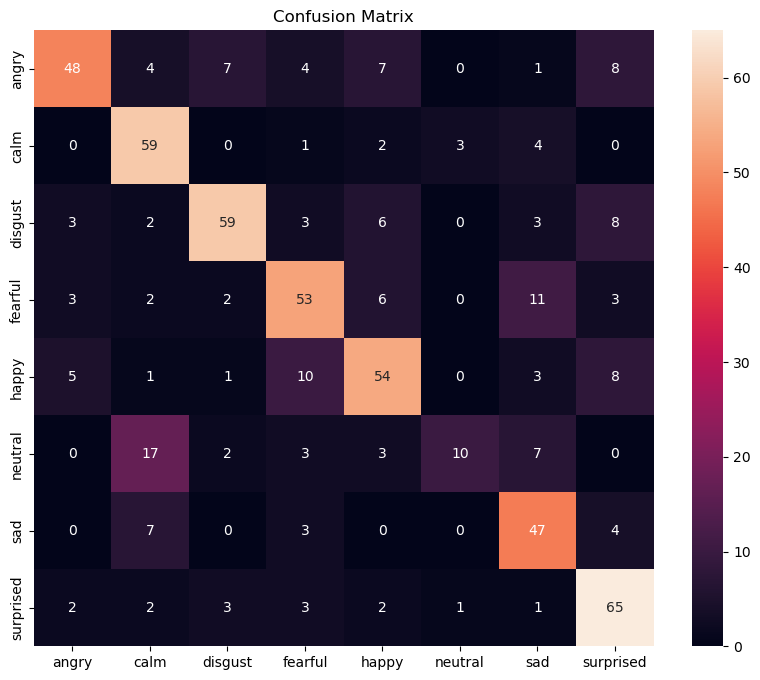

In [30]:
# Confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_classes), 
            annot=True, 
            fmt='d', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.show()